In [1]:
from pyrep import PyRep
import numpy as np
from matplotlib import pyplot as plt
from pyrep.objects.shape import Shape
from pyrep.const import PrimitiveShape
from pyrep.objects.vision_sensor import VisionSensor
from IPython import display

In [2]:
from matplotlib import cm
cols = cm.get_cmap('tab20c', 7)

In [3]:
f = open("soma_cube.txt", "r")
text = f.read()

split_sols = text.split('solution')
solutions = [split_sols[j] for j in range(1,241)]

solution_list = []
pic_list = []
for s in solutions:

    parts = s.split('\n')[1:8]
    solution_list.append(parts)

In [4]:
class BlockSim:
    
    def __init__(self,move_tolerance=1e-3):
        
        self.pr = PyRep()
        self.pr.launch(headless=False)
        
        self.pr.start()
        
        self.move_tolerance = move_tolerance
        
        self.blocks = ['T','p','V','L','Z','b','a']
    
    def reset(self):
        
        self.pr.stop()
        
    def setup(self,actions):

        self.pr.start()

        cam0 = VisionSensor.create([64,64],position=[0.1,0.1,0.5],orientation=[np.pi,0,0])
        cam1 = VisionSensor.create([64,64],position=[0.5,0.1,0.1],orientation=[0,-np.pi/2,-np.pi/2])
        cam2 = VisionSensor.create([64,64],position=[0.1,0.5,0.1],orientation=[np.pi/2,0,0])
        cam3 = VisionSensor.create([64,64],position=[0.1,-0.3,0.1],orientation=[-np.pi/2,0,-np.pi])

        # Make cube for 
        self.obj_list = []
        self.block_order = []
        for i,a in enumerate(actions):
            col_idx = self.blocks.index(a[-1])
            self.block_order.append(a[-1])
            color = (cols.colors[col_idx][0:3]).tolist()

            pose = np.array(' '.join(a[0:-1].split(',')).split()).reshape(-1,3).astype(int)*0.05 + 0.05
            block_list = []
            for p in pose:
                obj = Shape.create(type=PrimitiveShape.CUBOID, 
                              color=color, size=[0.05, 0.05, 0.05],
                              position=p.tolist())
                obj.set_color(color)
                block_list.append(obj)
            self.obj_list.append(block_list)

        for j in range(10):
            self.pr.step()
            
        im0 = cam0.capture_rgb()
        im1 = cam1.capture_rgb()
        im2 = cam2.capture_rgb()
        im3 = cam3.capture_rgb()

        self.pr.step()
        
        return (im0,im1,im2,im3)

    def remove(self,piece):
        try:
            idx = self.block_order.index(piece)
            parts = self.obj_list[idx]
            for p in parts:
                p.remove()
        except:
            print('No such piece. Not Removed.')
        for j in range(2):
            self.pr.step()
        
        return self.check_moving()
            
    def check_moving(self):
        vels = []
        for p in self.obj_list:
            for block in p:
                try:
                    t,w = block.get_velocity()
                    vels.append(np.sum(t**2)+np.sum(w**2))
                            
                except:
                    vels.append(0)
        if np.sum(np.array(vels) > self.move_tolerance) > 1:
            self.collapsed = True
            return True 
        else:
            return False

In [5]:
sim = BlockSim()

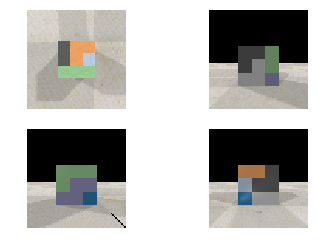

In [6]:
idx = 0
puzzle = solution_list[idx]
c = sim.setup(puzzle)

plt.clf()
plt.subplot(2,2,1)
plt.imshow(c[0])
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(c[1])
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(c[2])
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(c[3])
plt.axis('off')
plt.show()

In [7]:
key = {'Orange':'V','Green':'L','Black':'b','Purple':'Z','White':'a','LBlue':'p','Blue':'T'}

In [8]:
sim.reset()
sim.pr.shutdown()

In [9]:
extraction_orders_sink = np.load('pred_order.npy')
extraction_orders_tcn = np.load('pred_order_tcn.npy')
test_indices = np.load('test_indices.npy').astype(int)
test_indices_tcn = np.load('test_indices_tcn.npy').astype(int)

# Sanity check
print('Same indices:', np.array_equal(test_indices,test_indices_tcn))

Same indices: True


In [10]:
# Count failures Sink
counter_sink = np.zeros(test_indices.shape[0])
for i,idx in enumerate(test_indices.ravel()):
    puzzle = solution_list[idx]
    sim = BlockSim()
    c = sim.setup(puzzle)
    
    removal_list = extraction_orders_sink[i]
    
    collapsed = False
    for part in removal_list:
        collapsed = sim.remove(key[part])
        if collapsed:
            print('%d Collapsed!'%i)
            counter_sink[i]=counter_sink[i]+1
            sim.reset()
            break
        else:
            print('\r %d '%i,end='')
    sim.reset()
    sim.pr.shutdown()
    

 5 5 Collapsed!
 7 7 Collapsed!
 10 10 Collapsed!
 13 14 Collapsed!
 16 16 Collapsed!
 17 18 Collapsed!
 20 20 Collapsed!
 21 21 Collapsed!
 22 23 Collapsed!
 25 26 Collapsed!
 27 27 Collapsed!
 33 34 Collapsed!
 36 36 Collapsed!
 41 41 Collapsed!
 45 46 Collapsed!
47 Collapsed!
 48 48 Collapsed!
 49 49 Collapsed!
 52 52 Collapsed!
 53 53 Collapsed!
 56 56 Collapsed!
57 Collapsed!
 59 59 Collapsed!


In [11]:
print(np.sum(counter_sink)/len(counter_sink))

0.38333333333333336


In [12]:
# Count failures TCN
counter_tcn = np.zeros(test_indices.shape[0])
for i,idx in enumerate(test_indices.ravel()):
    puzzle = solution_list[idx]
    sim = BlockSim()
    c = sim.setup(puzzle)
    
    removal_list = extraction_orders_tcn[i]
    
    collapsed = False
    for part in removal_list:
        collapsed = sim.remove(key[part])
        if collapsed:
            print('%d Collapsed!'%i)
            counter_tcn[i]=counter_tcn[i]+1
            sim.reset()
            break
        else:
            print('\r %d '%i,end='')
    sim.reset()
    sim.pr.shutdown()

 0 0 Collapsed!
 1 1 Collapsed!
 4 4 Collapsed!
 6 6 Collapsed!
 7 7 Collapsed!
 8 8 Collapsed!
 10 10 Collapsed!
 11 11 Collapsed!
 13 13 Collapsed!
14 Collapsed!
 16 16 Collapsed!
 17 18 Collapsed!
 19 19 Collapsed!
 20 20 Collapsed!
 22 23 Collapsed!
 24 24 Collapsed!
 26 26 Collapsed!
 27 27 Collapsed!
 30 30 Collapsed!
 31 31 Collapsed!
 33 34 Collapsed!
 38 38 Collapsed!
 39 39 Collapsed!
 41 41 Collapsed!
 42 42 Collapsed!
 44 44 Collapsed!
 45 46 Collapsed!
47 Collapsed!
48 Collapsed!
 50 51 Collapsed!
 52 52 Collapsed!
53 Collapsed!
 56 56 Collapsed!
57 Collapsed!
 59 

In [13]:
print(np.sum(counter_tcn)/len(counter_tcn))

0.5666666666666667


In [14]:
def remove(sim,removal_list):
    
    collapsed = False
    count = 0
    for part in removal_list:
        collapsed = sim.remove(key[part])
        if collapsed:
            return collapsed, count
        else:
            count+=1
    return collapsed,count

In [15]:
def ga(sim,x,puzzle):
    
    best_count = 0
    iters = 0
    seq = x.copy()
    
    while True:
        c = sim.setup(puzzle)

        collapsed,count = remove(sim,seq)

        
        if count >= best_count:
            x = seq.copy()
            best_count = count
        
        if not collapsed:
            sim.reset()
            return x,iters 
        
        seq = x.copy()
        # randomly swap sequence
        bin_1 = best_count
        bin_2 = np.random.randint(count,7)

        temp = seq[bin_1]

        seq[bin_1] = seq[bin_2]
        seq[bin_2] = temp

        iters = iters+1
        sim.reset()

In [16]:
# Genetic algorithm solution - random initialisation
iter_counts = []
for idx in test_indices.ravel():
    sim = BlockSim()
    puzzle = solution_list[idx]
    init = np.array([k for k in key.keys()])
    np.random.shuffle(init)
    seq,iters = ga(sim,init,puzzle)
    iter_counts.append(iters)
    print('\r',len(iter_counts),end='')
    sim.pr.shutdown()

 60

In [17]:
# Genetic algorithm solution - sink initialisation
iter_counts_sink = []
for i,idx in enumerate(test_indices.ravel()):
    sim = BlockSim()
    puzzle = solution_list[idx]
    init = extraction_orders_sink[i]
    seq,iters = ga(sim,init,puzzle)
    iter_counts_sink.append(iters)
    print('\r',len(iter_counts_sink),end='')
    sim.pr.shutdown()

 60

In [18]:
# Genetic algorithm solution - tcn initialisation
iter_counts_tcn = []
for i,idx in enumerate(test_indices.ravel()):
    sim = BlockSim()
    puzzle = solution_list[idx]
    init = extraction_orders_tcn[i]
    seq,iters = ga(sim,init,puzzle)
    iter_counts_tcn.append(iters)
    print('\r',len(iter_counts_tcn),end='')
    sim.pr.shutdown()

 60

In [19]:
print('Average iterations, rand: %2.2f +- %2.2f'%(np.mean(iter_counts),np.std(iter_counts_tcn)))
print('Average iterations, tcn : %2.2f +- %2.2f'%(np.mean(iter_counts_tcn),np.std(iter_counts_tcn)))
print('Average iterations, sink: %2.2f +- %2.2f'%(np.mean(iter_counts_sink),np.std(iter_counts_sink)))

Average iterations, rand: 6.05 +- 3.01
Average iterations, tcn : 1.97 +- 3.01
Average iterations, sink: 1.60 +- 3.55


In [20]:
print('Average collapses, tcn: %2.2f'%np.mean(counter_tcn))
print('Average collapses, sink: %2.2f'%np.mean(counter_sink))

Average collapses, tcn: 0.57
Average collapses, sink: 0.38


In [21]:
import matplotlib
import seaborn as sns
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

plt.style.use('seaborn')

nice_fonts = {
        # Use LaTeX to write all text
        "text.usetex": True,
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 16,
        "font.size": 16,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 14,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
}

matplotlib.rcParams.update(nice_fonts)

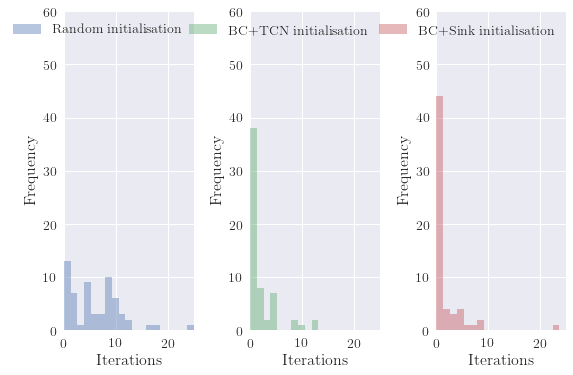

In [82]:
import itertools
palette = itertools.cycle(sns.color_palette())

plt.subplot(1,3,1)
sns.distplot(iter_counts,label='Random initialisation',bins=np.linspace(0,25,20),kde=False,color=next(palette))
plt.xlim(0,25)
plt.ylim(0,60)
plt.legend()
plt.ylabel('Frequency')
plt.xlabel('Iterations')
plt.subplot(1,3,2)
sns.distplot(iter_counts_tcn,label='BC+TCN initialisation',bins=np.linspace(0,25,20),kde=False,color=next(palette))
plt.xlim(0,25)
plt.ylim(0,60)
plt.legend()
plt.ylabel('Frequency')
plt.xlabel('Iterations')
plt.subplot(1,3,3)
sns.distplot(iter_counts_sink,label='BC+Sink initialisation',bins=np.linspace(0,25,20),kde=False,color=next(palette))
plt.xlim(0,25)
plt.ylim(0,60)
plt.ylabel('Frequency')
plt.xlabel('Iterations')
plt.legend(loc=0)
plt.tight_layout()
plt.savefig('ga_speedup.pdf')
plt.show()


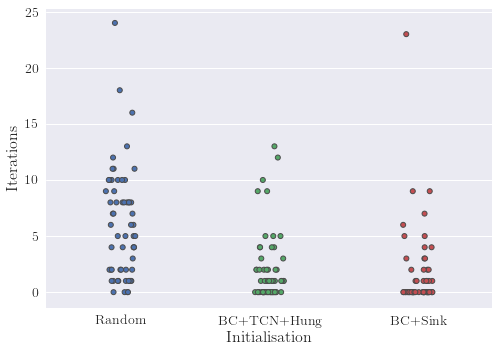

In [79]:
import pandas as pd
df1 = pd.DataFrame(iter_counts).assign(Initialisation='Random')
df2 = pd.DataFrame(iter_counts_tcn).assign(Initialisation='BC+TCN+Hung')
df3 = pd.DataFrame(iter_counts_sink).assign(Initialisation='BC+Sink')

cdf = pd.concat([df1, df2, df3]) 

mdf = pd.melt(cdf, id_vars=['Initialisation'])  
mdf.rename(columns={'value':'Iterations'},inplace=True)

ax = sns.stripplot(x='Initialisation', y="Iterations", data=mdf,linewidth=1)
#ax = sns.boxplot(x='Initialisation', y="Iterations", hue="Initialisation", data=mdf)  # RUN PLOT   
plt.show()